# Colonial Practice over time using Gaussian Processes

Here we build out a graph showing the practice of colonial science over time. This "parachute index" is defined as the number of papers where the First Author Affiliation (FA) does not much study site AND where the FA hdi > 0.9 and study site hdi <0.9, divided by the total number of papers published for given FA in given year. Essentially, we define a ratio of studies completed internally within a very highly developed nation, vs externally in less developed nations. Note that this requires the addition of human development indexes to the scopus export.

We then plot these as scatter graphs for various nations and find regressions using Gaussian Process regression.

This workbook shows an example for the United Kingdom.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
df = pd.read_csv("FINAL.csv")

In [55]:
study_country = df['Study Site']
affiliation_country = df['First Author Affiliation ']
study_hdi = df['Site HDI value']
affiliation_hdi = df['First Author HDI value']
pub_year = df['Year']

In [56]:
df_filtered = df[(study_country != affiliation_country) & (study_hdi < 0.9)]


In [57]:
df_affiliation = df[affiliation_hdi >= 0.9]

In [58]:
df_filtered_grouped = df_filtered.groupby(['Year', 'First Author Affiliation ']).size()
df_affiliation_grouped = df_affiliation.groupby(['Year', 'First Author Affiliation ']).size()


In [59]:
df_combined = pd.concat([df_filtered_grouped, df_affiliation_grouped], axis=1, keys=['filtered_count', 'affiliation_count']).fillna(0)
df_combined['ratio'] = df_combined['filtered_count'] / df_combined['affiliation_count']


In [60]:
df_combined

filtered_count  affiliation_count     ratio
Year   First Author Affiliation                                              
1967.0 United States                         1.0                1.0  1.000000
1972.0 United States                         1.0                6.0  0.166667
1973.0 Netherlands                           1.0                1.0  1.000000
1974.0 United States                         1.0                3.0  0.333333
1975.0 Netherlands                           1.0                2.0  0.500000
...                                          ...                ...       ...
2022.0 Ireland                               0.0                1.0  0.000000
       New Zealand                           0.0                1.0  0.000000
       Norway                                0.0                3.0  0.000000
       Singapore                             0.0                1.0  0.000000
       South Korea                           0.0                1.0  0.000000

[960 rows x 3 columns]

In [72]:
selected_country = 'United Kingdom'  # replace 'USA' with the country you're interested in
df_country_specific = df_combined.loc[(slice(None), selected_country), :]


In [73]:
df_country_specific.reset_index(level='First Author Affiliation ', drop=True, inplace=True)


In [74]:
df_country_specific = df_country_specific[df_country_specific.index >= 1980]

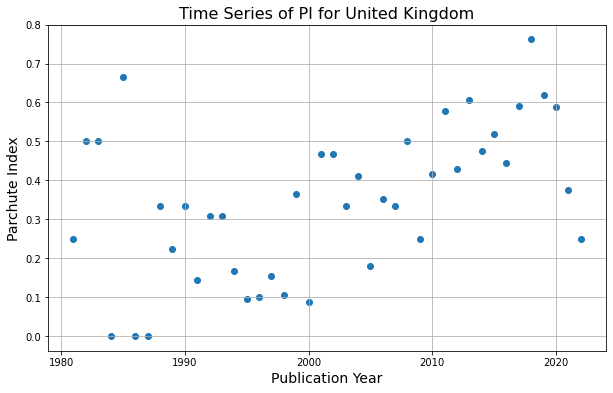

In [75]:


plt.figure(figsize=(10,6))
plt.scatter(df_country_specific.index, df_country_specific['ratio'], marker='o', linestyle='-')

plt.xlabel('Publication Year', fontsize=14)
plt.ylabel('Parchute Index', fontsize=14)
plt.title('Time Series of PI for ' + selected_country, fontsize=16)
plt.grid(True)

plt.show()


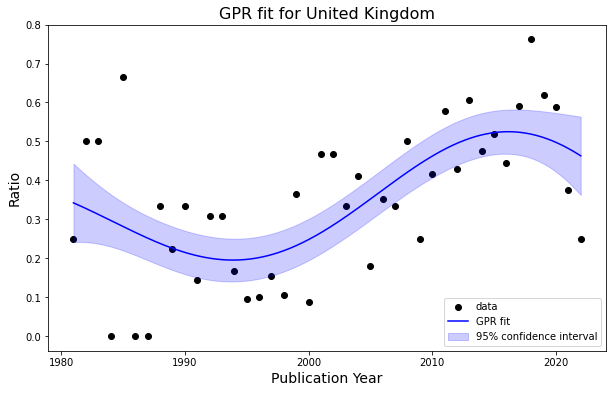

In [77]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


# Define kernel parameters
kernel = C(1.5, (1e-3, 1e3)) * RBF(5, (1e-2, 1e2))

# Create a GaussianProcessRegressor object.
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.01)

# Training data
X = np.array(df_country_specific.index).reshape(-1, 1)
y = df_country_specific['ratio']

# Fit to data using Maximum Likelihood Estimation of the parameters
gpr.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
X_pred = np.linspace(X.min(), X.max(), 1000).reshape(-1, 1)
y_pred, sigma = gpr.predict(X_pred, return_std=True)

# Plot the function, the prediction and the 95% confidence interval
plt.figure(figsize=(10,6))
plt.scatter(X, y, c='k', label='data')
plt.plot(X_pred, y_pred, color='b', label='GPR fit')
plt.fill_between(X_pred.ravel(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, color='b', alpha=0.2, label='95% confidence interval')
plt.xlabel('Publication Year', fontsize=14)
plt.ylabel('Ratio', fontsize=14)
plt.title('GPR fit for ' + selected_country, fontsize=16)
plt.legend()
plt.show()


Essentially, we see that colonial practice as defined by the parachute index seemed to increase for UK researchers between 1990-2010, but now seems to be coming down